# Super Resolution using Deeply-Recursive Convolutional Network

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
# from keras import mixed_precision

# Ensure TensorFlow is using GPU if available
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


2024-10-26 15:55:55.739994: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-26 15:55:55.965219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 15:55:55.994591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 15:55:56.010144: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 15:55:56.281301: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version: 2.17.0
GPU is available


# 1. Data Preparation

In [4]:
dir = os.getcwd()
print(dir)

/home/student/deep-machine-learning/DML_PROJECT/DRCN


2024-10-26 15:59:04.229118: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20750 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008359462..0.9927359].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00532516..0.9868197].


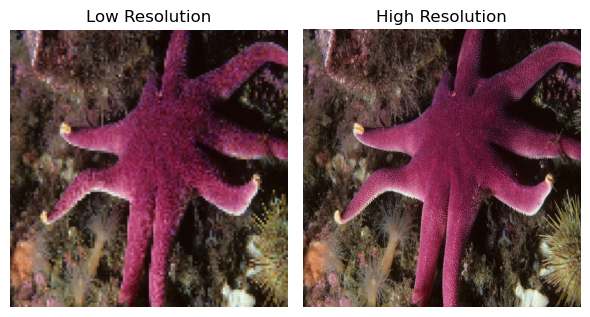

Low resolution shape: (128, 128, 3)
High resolution shape: (512, 512, 3)


In [5]:

def preprocess_image(image_path, scale=4, target_size=(128,128)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    
    # Resize high-resolution image to target size * scale
    high_res = tf.image.resize(image, [target_size[0]*scale, target_size[1]*scale], method='bicubic')
    
    # Create low-resolution image
    low_res = tf.image.resize(high_res, target_size, method='bicubic')
    
    return low_res, high_res


def visualize_preprocessed_image(low_res, high_res):
    plt.figure(figsize=(6, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(low_res)
    plt.title('Low Resolution')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(high_res)
    plt.title('High Resolution')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Path to your image
image_path = os.path.join(dir,'DIV2K_train_HR/0001.png')

# Preprocess the image
low_res, high_res = preprocess_image(image_path, scale=4, target_size=(128,128))

# Visualize the preprocessed image
visualize_preprocessed_image(low_res, high_res)

# Print shapes for verification
print(f"Low resolution shape: {low_res.shape}")
print(f"High resolution shape: {high_res.shape}")


# 2. Load Dataset

In [6]:
def load_dataset(dir_path, batch_size=32, scale=4):
    """
    Load and prepare the DIV2K dataset from a specific directory.
    """
    # Get all image paths
    image_paths = glob.glob(os.path.join(dir_path, '*.png'))
    
    # Create a dataset of file paths
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    
    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    
    # Preprocess and batch the dataset
    dataset = dataset.map(lambda x: preprocess_image(x, scale), 
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Load the datasets
train_dir = os.path.join(dir,'DIV2K_train_HR' ) 
valid_dir = os.path.join(dir,'DIV2K_valid_HR' )

train_dataset = load_dataset(train_dir, batch_size=8, scale=4)
val_dataset = load_dataset(valid_dir, batch_size=8, scale=4)

print("Datasets created successfully.")
print("Number of batches in training set:", tf.data.experimental.cardinality(train_dataset).numpy())
print("Number of batches in validation set:", tf.data.experimental.cardinality(val_dataset).numpy())

Datasets created successfully.
Number of batches in training set: 100
Number of batches in validation set: 13


# 2. Model Architecture

In [5]:
class DRCN(tf.keras.Model):
    def __init__(self, num_filters=256, num_recursive=16, cnn_size=3, channels=3, scale=4, **kwargs):
        super(DRCN, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.num_recursive = num_recursive
        self.cnn_size = cnn_size
        self.channels = channels
        self.scale = scale
        # self.dtype = tf.float32 

        # Embedding network
        self.embedding_network = tf.keras.Sequential([
            tf.keras.layers.Conv2D(num_filters, cnn_size, padding='same', activation='relu', name='conv_m1'),
            tf.keras.layers.Conv2D(num_filters, cnn_size, padding='same', activation='relu', name='conv_0')
        ])

        # Inference (recursive) network
        self.recursive_layer = tf.keras.layers.Conv2D(num_filters, cnn_size, padding='same', activation='relu', name='recursive_conv')
      
        # Reconstruction network
        self.reconstruction_network = tf.keras.Sequential([
        tf.keras.layers.Conv2D(num_filters, cnn_size, padding='same', activation='relu', name='reconstruction_conv1'),
        tf.keras.layers.Conv2D(channels * (scale ** 2), cnn_size, padding='same', name='reconstruction_conv2'),
        tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale)),
        tf.keras.layers.Conv2D(channels, cnn_size, padding='same', activation='sigmoid', name='reconstruction_conv3')  # Sigmoid to scale to [0, 1]
        ])
        
        # Layer weights for combining recursive outputs
        self.layer_weights = self.add_weight(name="LayerWeights", 
                                     shape=(num_recursive,),
                                     initializer=tf.constant_initializer(1.0 / num_recursive),
                                     trainable=True)
                                     # dtype=self.dtype)

    def call(self, inputs, training=False):
        # Embedding
        inputs = tf.cast(inputs, self.dtype)
        x = self.embedding_network(inputs)
        
        
        # Recursive inference
        recursive_outputs = []
        for i in range(self.num_recursive):
            x = self.recursive_layer(x)
            recursive_outputs.append(x)
            
        
        # Reconstruction
        outputs = []
        for i, rec_output in enumerate(recursive_outputs):
            y = self.reconstruction_network(rec_output)
            outputs.append(y * self.layer_weights[i])
        
        
        # Combine outputs
        final_output = tf.add_n(outputs)
        
    
        
        def compute_output_shape(self, input_shape):
        # Compute the output shape based on the input shape
            return (input_shape[0], input_shape[1] * self.scale, input_shape[2] * self.scale, self.channels)

        return final_output, recursive_outputs

def build_drcn_model(num_filters=256, num_recursive=16, cnn_size=3, channels=3,scale=4):
    model = DRCN(num_filters, num_recursive, cnn_size, channels,scale)
    # Build the model with a sample input
    sample_input = tf.keras.Input(shape=(128,128,channels))
    model(sample_input)
    return model

model = build_drcn_model(num_filters=256, num_recursive=16, cnn_size=3, channels=3, scale=4)
model.summary()

Model: "drcn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 256)  │       597,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ recursive_conv (Conv2D)         │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 512, 512, 3)    │       700,804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,888,148 (7.20 MB)

 Trainable params: 1,888,148 (7.20 MB)

 Non-trainable params: 0 (0.00 B)

# 3. Training

In [6]:
#Define the loss function

def color_loss(y_true, y_pred):
    # Separate RGB channels
    y_true_r, y_true_g, y_true_b = tf.split(y_true, 3, axis=-1)
    y_pred_r, y_pred_g, y_pred_b = tf.split(y_pred, 3, axis=-1)
    
    # Calculate mean squared error for each channel
    mse_r = tf.reduce_mean(tf.square(y_true_r - y_pred_r))
    mse_g = tf.reduce_mean(tf.square(y_true_g - y_pred_g))
    mse_b = tf.reduce_mean(tf.square(y_true_b - y_pred_b))
    
    # Calculate color difference 
    color_diff = mse_r + mse_g + mse_b
    
    return color_diff
def drcn_loss(y_true, y_pred, recursive_outputs, model, loss_alpha=1.0, loss_beta=0.0, color_weight=0.1):
# def drcn_loss(y_true, y_pred, recursive_outputs, model, loss_alpha=1.0, loss_beta=0.0):
    mse = tf.reduce_mean(tf.square(y_pred - y_true))
    color = color_loss(y_true, y_pred)
    
    if loss_alpha == 0.0 or model.num_recursive == 0:
        return mse + color_weight * color
    # + color_weight * color
    alpha_mses = []
    for i in range(model.num_recursive):
        y_output = model.reconstruction_network(recursive_outputs[i])
        alpha_mses.append(tf.reduce_mean(tf.square(y_true - y_output)))
    
    alpha_loss = tf.reduce_mean(alpha_mses)
    loss = (1 - loss_alpha) * mse + loss_alpha * alpha_loss + color_weight * color
    # + color_weight * color
    if loss_beta > 0.0:
        l2_loss = sum(tf.nn.l2_loss(w) for w in model.trainable_weights)
        loss += loss_beta * l2_loss
    
    return loss

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006)


# Define the training step
@tf.function


def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        predictions, recursive_outputs = model(x, training=True)
        y_resized = tf.image.resize(y, tf.shape(predictions)[1:3])
        loss = drcn_loss(y_resized, predictions, recursive_outputs, model)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, predictions

def calculate_psnr_direct(y_true, y_pred, max_val=1.0):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=max_val))




# Training loop


In [10]:


def train_model(model, train_dataset, val_dataset, epochs=5):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_psnr': [],
        'val_psnr': [],
        'train_perceptual_index': [],
        'val_perceptual_index': []
    }
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training
        train_loss = 0
        train_psnr = 0
        train_steps = 0
        for x_batch, y_batch in train_dataset:
            loss, predictions = train_step(model, x_batch, y_batch, optimizer)
            train_loss += loss
            train_psnr += calculate_psnr_direct(y_batch, predictions)
            train_steps += 1
        
        train_loss /= train_steps
        train_psnr /= train_steps
        train_perceptual_index = (10 - train_psnr) / 2  
        
        # Validation
        val_loss = 0
        val_psnr = 0
        val_ssim = 0
        val_steps = 0
        for x_batch, y_batch in val_dataset:
            predictions, recursive_outputs = model(x_batch, training=False)
            y_resized = tf.image.resize(y_batch, tf.shape(predictions)[1:3])
            val_loss += drcn_loss(y_resized, predictions, recursive_outputs, model)
            val_psnr += calculate_psnr_direct(y_resized, predictions)
            val_ssim += tf.reduce_mean(tf.image.ssim(y_resized, predictions, max_val=1.0))
            val_steps += 1
        
        val_loss /= val_steps
        val_psnr /= val_steps
        val_ssim /= val_steps
        val_perceptual_index = (10 - val_ssim) / 2 + (10 - val_psnr) / 2
        
        # Store the metrics
        history['train_loss'].append(train_loss.numpy())
        history['val_loss'].append(val_loss.numpy())
        history['train_psnr'].append(train_psnr.numpy())
        history['val_psnr'].append(val_psnr.numpy())
        history['train_perceptual_index'].append(train_perceptual_index.numpy())
        history['val_perceptual_index'].append(val_perceptual_index.numpy())
        
        print(f"Train Loss: {train_loss:.4f}, Train PSNR: {train_psnr:.2f}, Train PI: {train_perceptual_index:.2f}")
        print(f"Val Loss: {val_loss:.4f}, Val PSNR: {val_psnr:.2f}, Val SSIM: {val_ssim:.4f}, Val PI: {val_perceptual_index:.2f}")
        
        # Save the model periodically
        if (epoch + 1) % 10 == 0:
            model.save_weights(f'drcn_model_epoch_{epoch+1}.weights.h5')

    return history
    
# Train the model
history = train_model(model, train_dataset, val_dataset, epochs=70)
model.save('drcn_final_model.h5')

Epoch 1/70


W0000 00:00:1729692435.279702    4542 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729692435.281070    4542 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729692435.282243    4542 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729692435.283368    4542 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729692435.284502    4542 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729692435.285631    4542 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729692435.286824    4542 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729692435.287944    4542 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729692435.289213    4542 gp

Train Loss: 0.0639, Train PSNR: 14.19, Train PI: -2.10
Val Loss: 0.0333, Val PSNR: 16.55, Val SSIM: 0.3736, Val PI: 1.54
Epoch 2/70
Train Loss: 0.0261, Train PSNR: 17.74, Train PI: -3.87
Val Loss: 0.0211, Val PSNR: 18.72, Val SSIM: 0.4532, Val PI: 0.41
Epoch 3/70
Train Loss: 0.0202, Train PSNR: 18.86, Train PI: -4.43
Val Loss: 0.0190, Val PSNR: 19.18, Val SSIM: 0.4649, Val PI: 0.18
Epoch 4/70
Train Loss: 0.0169, Train PSNR: 19.71, Train PI: -4.85
Val Loss: 0.0175, Val PSNR: 19.57, Val SSIM: 0.4967, Val PI: -0.03
Epoch 5/70
Train Loss: 0.0170, Train PSNR: 19.75, Train PI: -4.87
Val Loss: 0.0210, Val PSNR: 18.74, Val SSIM: 0.4907, Val PI: 0.38
Epoch 6/70
Train Loss: 0.0168, Train PSNR: 19.78, Train PI: -4.89
Val Loss: 0.0161, Val PSNR: 19.96, Val SSIM: 0.5396, Val PI: -0.25
Epoch 7/70
Train Loss: 0.0165, Train PSNR: 19.86, Train PI: -4.93
Val Loss: 0.0160, Val PSNR: 19.99, Val SSIM: 0.5368, Val PI: -0.26
Epoch 8/70
Train Loss: 0.0150, Train PSNR: 20.29, Train PI: -5.14
Val Loss: 0.0177, 

2024-10-23 15:42:02.264674: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 0.0125, Train PSNR: 21.31, Train PI: -5.66
Val Loss: 0.0124, Val PSNR: 21.28, Val SSIM: 0.5908, Val PI: -0.93
Epoch 32/70
Train Loss: 0.0121, Train PSNR: 21.47, Train PI: -5.74
Val Loss: 0.0117, Val PSNR: 21.52, Val SSIM: 0.6046, Val PI: -1.06
Epoch 33/70
Train Loss: 0.0115, Train PSNR: 21.68, Train PI: -5.84
Val Loss: 0.0129, Val PSNR: 21.11, Val SSIM: 0.6001, Val PI: -0.85
Epoch 34/70
Train Loss: 0.0126, Train PSNR: 21.31, Train PI: -5.66
Val Loss: 0.0122, Val PSNR: 21.38, Val SSIM: 0.6012, Val PI: -0.99
Epoch 35/70
Train Loss: 0.0116, Train PSNR: 21.64, Train PI: -5.82
Val Loss: 0.0115, Val PSNR: 21.59, Val SSIM: 0.6048, Val PI: -1.10
Epoch 36/70
Train Loss: 0.0114, Train PSNR: 21.72, Train PI: -5.86
Val Loss: 0.0122, Val PSNR: 21.37, Val SSIM: 0.6005, Val PI: -0.98
Epoch 37/70
Train Loss: 0.0115, Train PSNR: 21.68, Train PI: -5.84
Val Loss: 0.0116, Val PSNR: 21.56, Val SSIM: 0.5983, Val PI: -1.08
Epoch 38/70
Train Loss: 0.0115, Train PSNR: 21.68, Train PI: -5.84
Val Los

Train Loss: 0.0112, Train PSNR: 21.83, Train PI: -5.92
Val Loss: 0.0112, Val PSNR: 21.77, Val SSIM: 0.6133, Val PI: -1.19


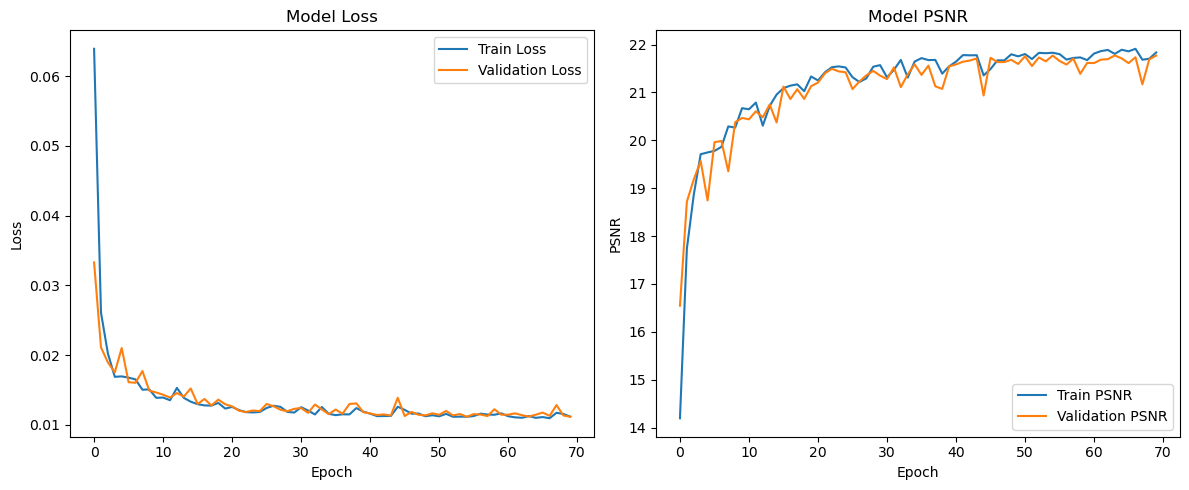

In [11]:

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation PSNR values
plt.subplot(1, 2, 2)
plt.plot(history['train_psnr'], label='Train PSNR')
plt.plot(history['val_psnr'], label='Validation PSNR')
plt.title('Model PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()

plt.tight_layout()
plt.show()

2024-10-24 21:35:15.774970: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300
W0000 00:00:1729805716.161817    3659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729805716.202248    3659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729805716.214965    3659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729805716.215425    3659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729805716.215924    3659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729805716.216417    3659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729805716.275702    3659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729805716.279400    3659 gpu_

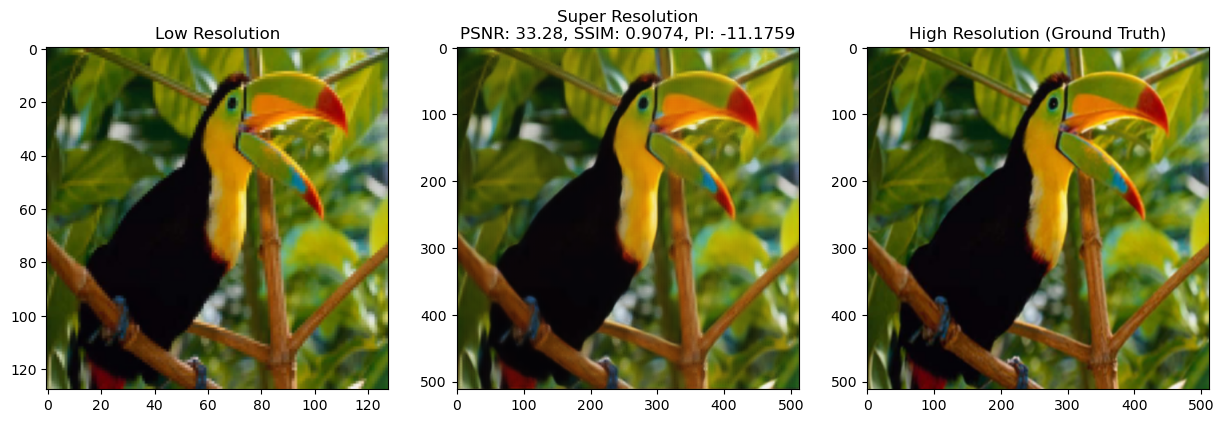

Average PSNR: 31.86
Average SSIM: 0.8876
Average PI: -10.3662

Individual scores:
Image  1: PSNR = 33.28, SSIM = 0.9074, PI = -11.1759
Image  2: PSNR = 29.77, SSIM = 0.8208, PI = -8.9900
Image  3: PSNR = 30.49, SSIM = 0.9258, PI = -9.8742
Image  4: PSNR = 32.24, SSIM = 0.9346, PI = -10.7929
Image  5: PSNR = 33.50, SSIM = 0.8494, PI = -10.9983

PSNR Standard Deviation: 1.49
SSIM Standard Deviation: 0.0447
PI Standard Deviation: 0.8214


In [7]:
import glob
import numpy as np
from tensorflow import keras

def preprocess_test_image(image_path, scale=4, target_size=(512,512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    
    # Create high-res image
    high_res = tf.image.resize(image, target_size)
    high_res = tf.cast(high_res, tf.float32) / 255.0
    
    # Create low-res image
    low_res_size = (target_size[0] // scale, target_size[1] // scale)
    low_res = tf.image.resize(high_res, low_res_size, method='bicubic')
    
    return low_res, high_res

def evaluate_model(model, test_image_paths):
    psnr_scores = []
    ssim_scores = []
    pi_scores = []
    example_shown = False
    
    for test_path in test_image_paths:
        # Load and preprocess the test image
        low_res, high_res = preprocess_test_image(test_path, scale=4, target_size=(512,512))
        low_res = tf.expand_dims(low_res, 0)  # Add batch dimension

        # Generate sr image
        sr_image, _ = model(low_res)
        sr_image = tf.squeeze(sr_image, 0)  # Remove batch dimension
        sr_image = tf.clip_by_value(sr_image, 0, 1)
        
        # Calculate metrics
        psnr_score = tf.image.psnr(high_res, sr_image, max_val=1.0)
        ssim_score = tf.image.ssim(high_res, sr_image, max_val=1.0)
        pi_score = (10 - psnr_score) / 2 + (10 - ssim_score * 10) / 2  # Simplified PI calculation
        
        psnr_scores.append(psnr_score)
        ssim_scores.append(ssim_score)
        pi_scores.append(pi_score)

        # Display one example image
        if not example_shown:
            plt.figure(figsize=(15, 5))
            plt.subplot(131)
            plt.imshow(tf.squeeze(low_res, 0))
            plt.title('Low Resolution')
            plt.subplot(132)
            plt.imshow(sr_image)
            plt.title(f'Super Resolution\nPSNR: {psnr_score:.2f}, SSIM: {ssim_score:.4f}, PI: {pi_score:.4f}')
            plt.subplot(133)
            plt.imshow(high_res)
            plt.title('High Resolution (Ground Truth)')
            # plt.tight_layout()
            plt.show()
            example_shown = True
    
    average_psnr = tf.reduce_mean(psnr_scores)
    average_ssim = tf.reduce_mean(ssim_scores)
    average_pi = tf.reduce_mean(pi_scores)
    
    return average_psnr, average_ssim, average_pi, psnr_scores, ssim_scores, pi_scores

# Usage
model = build_drcn_model()

model.load_weights('drcn_final_model.h5')

test_image_paths = glob.glob('/home/student/deep-machine-learning/DML_PROJECT/DRCN/set5/*.png')

# Evaluate the model
average_psnr, average_ssim, average_pi, psnr_scores, ssim_scores, pi_scores = evaluate_model(model, test_image_paths)

print(f"Average PSNR: {average_psnr:.2f}")
print(f"Average SSIM: {average_ssim:.4f}")
print(f"Average PI: {average_pi:.4f}")

# Print individual scores
print("\nIndividual scores:")
for i, (psnr, ssim, pi) in enumerate(zip(psnr_scores, ssim_scores, pi_scores), 1):
    print(f"Image {i:2d}: PSNR = {psnr:.2f}, SSIM = {ssim:.4f}, PI = {pi:.4f}")

# Calculate and print standard deviations
psnr_std = np.std(psnr_scores)
ssim_std = np.std(ssim_scores)
pi_std = np.std(pi_scores)

print(f"\nPSNR Standard Deviation: {psnr_std:.2f}")
print(f"SSIM Standard Deviation: {ssim_std:.4f}")
print(f"PI Standard Deviation: {pi_std:.4f}")

## Computational efficiency

In [8]:
num_params = model.count_params()
print(f"Number of parameters in DRCN: {num_params}")

Number of parameters in DRCN: 1888148


In [9]:
model.summary()

Model: "drcn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 128, 128, 256)  │       597,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ recursive_conv (Conv2D)         │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 512, 512, 3)    │       700,804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,888,148 (7.20 MB)

 Trainable params: 1,888,148 (7.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import time
# Prepare a sample input (low-resolution image)
sample_input = np.random.rand(1, 128, 128, 3).astype(np.float32) 

# Measure inference time
start_time = time.time()
sr_image = model(sample_input) 
end_time = time.time()

inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print(f"Inference time for DRCN: {inference_time:.2f} ms")

Inference time for DRCN: 101.54 ms


In [11]:
from memory_profiler import memory_usage

# Function to measure memory usage
def model_memory_usage():
    sr_image = model(sample_input)

# Measure memory usage
mem_usage = memory_usage(model_memory_usage)
print(f"Memory usage during inference: {max(mem_usage) - min(mem_usage):.2f} MB")

Memory usage during inference: 0.21 MB
